In [2]:
# HIDDEN

from datascience import *
import numpy as np

import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')


### A/B Testing ###

We have used random permutations to see whether two samples are drawn from the same underlying categorical distribution. If the samples are numerical, the same method can be used; the choice of test statistic is usually simpler. In our example with the Deflategate data, we used the difference of means to test whether the Patriots' and Colts' balls came from the same underlying distribution.

In modern data analytics, deciding whether two numerical samples come from the same underlying distribution is called *A/B testing*. The name refers to the labels of the two samples, A and B.

### Smokers and Nonsmokers ###
We have performed many different analyses on our random sample of mothers and their newborn infants, but we haven't yet looked at the data whether the mothers smoked. One of the aims of the study was to see whether maternal smoking was associated with birth weight. 

In [37]:
baby = Table.read_table('baby.csv')
baby

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


We'll start by selecting just `Birth Weight` and `Maternal Smoker`. There are 715 non-smokers among the women in the sample, and 459 smokers.

In [38]:
weight_smoke = baby.select('Birth Weight', 'Maternal Smoker')

In [39]:
weight_smoke.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


The first histogram below displays the distribution of birth weights of the babies of the non-smokers in the sample. The second displays the birth weights of the babies of the smokers.

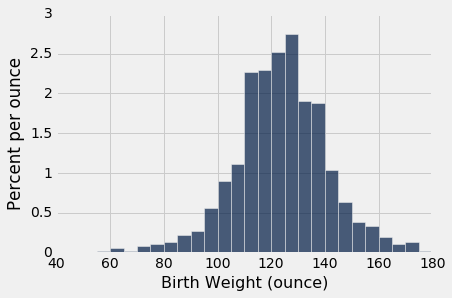

In [40]:
nonsmokers = baby.where('Maternal Smoker', are.equal_to(False))
nonsmokers.hist('Birth Weight', bins=np.arange(40, 181, 5), unit='ounce')

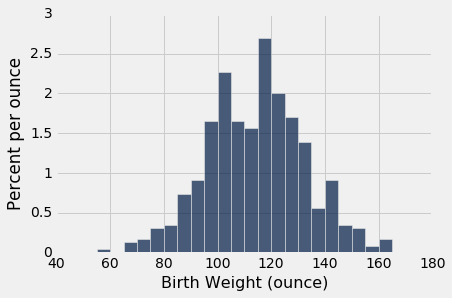

In [41]:
smokers = baby.where('Maternal Smoker', are.equal_to(True))
smokers.hist('Birth Weight', bins=np.arange(40, 181, 5), unit='ounce')

Both distributions are approximately bell shaped and centered near 120 ounces. The distributions are not identical, of course, which raises the question of whether the difference reflects just chance variation or a difference in the distributions in the population.

This question can be answered by a test of hypotheses. 

**Null hypothesis:** In the population, the distribution of birth weights of babies is the same for mothers who don't smoke as for mothers who do. The difference in the sample is due to chance.

**Alternative hypothesis:** The two distributions are different in the population.

**Test statistic:** Birth weight is a quantitative variable, so it is reasonable to use the absolute difference between the means as the test statistic.

The observed value of the test statistic is about 9.27 ounces.

In [42]:
means_table = weight_smoke.group('Maternal Smoker', np.mean)
means_table

Maternal Smoker,Birth Weight mean
False,123.085
True,113.819


In [17]:
nonsmokers_mean = means_table.column(1).item(0)
smokers_mean = means_table.column(1).item(1)
nonsmokers_mean - smokers_mean

9.266142572024918

### A Permutation Test ###

To see whether such a difference could have arisen due to chance under the null hypothesis, we will use a permutation test just as we did in the previous section. All we have to change is the code for the test statistic. For that, we'll compute the difference in means as we did above, and then take the absolute value.

Remember that under the null hypothesis, all permutations of birth weight are equally likely to be appear with the `Maternal Smoker` column. So, just as before, each repetition starts with shuffling the variable being compared.

In [24]:
def permutation_test_means(table, variable, classes, repetitions):
    
    """Test whether two numerical samples 
    come from the same underlying distribution, 
    using the absolute difference between the means.
    table: name of table containing the sample
    variable: label of column containing the numerical variable 
    classes: label of column containing names of the two samples
    repetitions: number of random permutations"""
    
    t = table.select(variable, classes)
    
    # Find the observed test statistic
    means_table = t.group(classes, np.mean) 
    obs_stat = abs(means_table.column(1).item(0) - means_table.column(1).item(1))
    
    # Assuming the null is true, randomly permute the variable 
    # and collect all the generated test statistics
    stats = make_array()
    for i in np.arange(repetitions):
        shuffled_var = t.select(variable).sample(with_replacement=False).column(0)
        shuffled = t.select(classes).with_column('Shuffled Variable', shuffled_var)
        m_tbl = shuffled.group(classes, np.mean)
        new_stat = abs(m_tbl.column(1).item(0) - m_tbl.column(1).item(1))
        stats = np.append(stats, new_stat)
    
    # Find the empirical P-value:
    emp_p = np.count_nonzero(stats >= obs_stat)/repetitions

    # Draw the empirical histogram of the tvd's generated under the null, 
    # and compare with the value observed in the original sample
    Table().with_column('Test Statistic', stats).hist(bins=20)
    plots.title('Empirical Distribution Under the Null')
    print('Observed statistic:', obs_stat)
    print('Empirical P-value:', emp_p)

Observed statistic: 9.266142572024918
Empirical P-value: 0.0


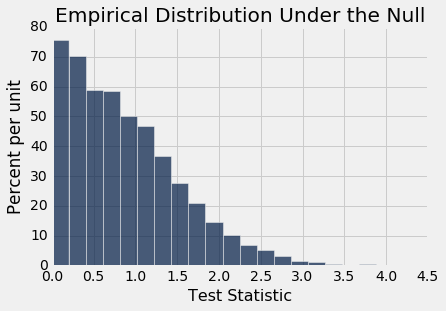

In [23]:
permutation_test_means(baby, 'Birth Weight', 'Maternal Smoker', 5000)

The observed difference in the original sample is about 9.27 ounces, which is inconsistent with this distribution: the empirical P-value is 0, implying that the exact P-value is very small indeed. So the conclusion of the test is that in the population, the distributions of birth weights of the babies of non-smokers and smokers are different.

### Bootstrap Confidence Interval For the Difference ###

Our A/B test has concluded that the two distributions are different, but that's a little unsatisfactory. How different are they? Which one has the larger mean? These are natural questions that the test can't answer.

Recall that we've had this discussion before: instead of just asking a yes/no question about whether the two distributions are different, we might learn more by not making any hypotheses and simply estimating the difference between the means.

The observed difference (nonsmokers $-$ smokers) was about 9.27 ounces; the positive sign says that the non-smoking mothers had larger babies on average. But samples could have come out differently due to randomness. To see how different, we have to generate more samples; to generate more samples, we'll use the bootstrap as we have done many times before. The bootstrap makes no hypotheses about whether or not the two distributions are the same. It simply replicates the original random sample and computes new values of the statistic.

The function `bootstrap_ci_means` returns a bootstrap confidence interval for the difference between the means of the two groups in the population. In our example, the confidence interval would estimate the difference between the average birth weights of babies of mothers who didn't smoke and mothers who did, in the entire population.

- the name of the table that contains the data in the original sample
- the label of the column containing the numerical variable
- the label of the column containing the names of the two samples
- the number of bootstrap repetitions

The function returns an approximate 95% confidence interval for the difference between the two means, using the bootstrap percentile method.

In [33]:
def bootstrap_ci_means(table, variable, classes, repetitions):
    
    """Bootstrap approximate 95% confidence interval
    for the difference between the means of the two classes
    in the population"""
    
    t = table.select(variable, classes)
    
    mean_diffs = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = t.sample()
        m_tbl = bootstrap_sample.group(classes, np.mean)
        new_stat = m_tbl.column(1).item(0) - m_tbl.column(1).item(1)
        mean_diffs = np.append(mean_diffs, new_stat)
        
    left = percentile(2.5, mean_diffs)
    right = percentile(97.5, mean_diffs)
    
    # Find the observed test statistic
    means_table = t.group(classes, np.mean) 
    obs_stat = means_table.column(1).item(0) - means_table.column(1).item(1)
    
    Table().with_column('Difference Between Means', mean_diffs).hist(bins=20)
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8)
    print('Observed difference between means:', obs_stat)
    print('Approximate 95% CI for the difference between means:')
    print(left, 'to', right)

Observed difference between means: 9.266142572024918
Approximate 95% CI for the difference between means:
7.23940878698 to 11.3907887554


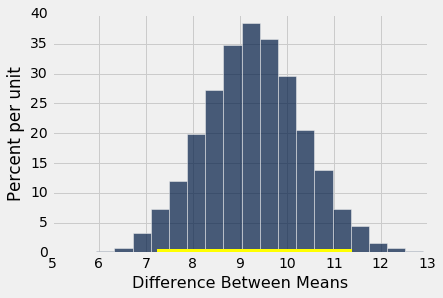

In [35]:
bootstrap_ci_means(baby, 'Birth Weight', 'Maternal Smoker', 5000)

The non-smoking mothers had babies that were about 7.2 ounces to 11.4 ounces heavier, on average, than the babies of the mothers who smoked. This is a more useful conclusion than "the two distributions are different." And because the confidence interval doesn't contain 0, it also tells us that the two distributions are different. So the confidence interval gives us an estimate of the difference between the means and also lets us decide whether or not the two underlying distributions are the same.

The non-smoking mothers were a little older, on average, than the mothers who smoked.

Observed difference between means: 0.8076725017901509
Approximate 95% CI for the difference between means:
0.154278698588 to 1.4701157656


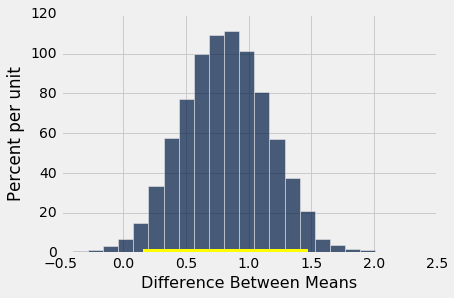

In [43]:
bootstrap_ci_means(baby, 'Maternal Age', 'Maternal Smoker', 5000)

But not surprisingly, the evidence doesn't point to their heights being any different, on average, than those of the mothers who didn't smoke. Zero is in the confidence interval for the difference between the means.

Observed difference between means: 0.09058914941267915
Approximate 95% CI for the difference between means:
-0.390841928035 to 0.204388297872


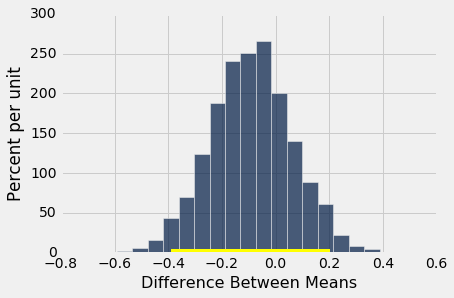

In [44]:
bootstrap_ci_means(baby, 'Maternal Height', 'Maternal Smoker', 5000)

In summary:

- If you want to tell whether or not two underlying distributions are the same, you can use a permutation test with an appropriate test statistic. We used the total variation distance when the distributions were categorical, and the absolute difference between means when the distributions were numerical.

- To compare two numerical distributions, it's often more informative to replace hypothesis testing by estimation. Just estimate a difference, such as the difference between the means of the two groups. This can be done by constructing a bootstrap confidence interval. If zero is not in the interval, you can conclude that the two distributions are different and you also have an estimate of how different the means are.